<a href="https://www.kaggle.com/code/george1128/blood-cell-identification-with-images?scriptVersionId=272477310" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#"This work is using the 'Blood cell images' to show the reusable code for image automentation and pipieline of deep learning. The dataset is from Paul Mooney. https://www.kaggle.com/datasets/paultimothymooney/blood-cells"

In [3]:
#import models
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers import Lambda, BatchNormalization
#import numpy as np # linear algebra
#import pandas as pd


2025-10-28 15:47:33.714130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761666453.896501      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761666453.963336      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
#reads a blood cell image and its corresponding annotation XML file
def annotate_image(image_path, xml_path):
    image = cv2.imread(image_path)
    tree = ET.parse(xml_path)

    for elem in tree.iter():
        if 'object' in elem.tag or 'part' in elem.tag:
            name, xmin, ymin, xmax, ymax = None, None, None, None, None
            for attr in list(elem):
                if 'name' in attr.tag:
                    name = attr.text
                if 'bndbox' in attr.tag:
                    coords = {dim.tag: int(round(float(dim.text))) for dim in list(attr)}
                    xmin, ymin, xmax, ymax = coords['xmin'], coords['ymin'], coords['xmax'], coords['ymax']

            if name:
                color = (0, 255, 0) if name[0] == "R" else (0, 0, 255) if name[0] == "W" else (255, 0, 0)
                cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 1)
                cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], color, 1)
    return image

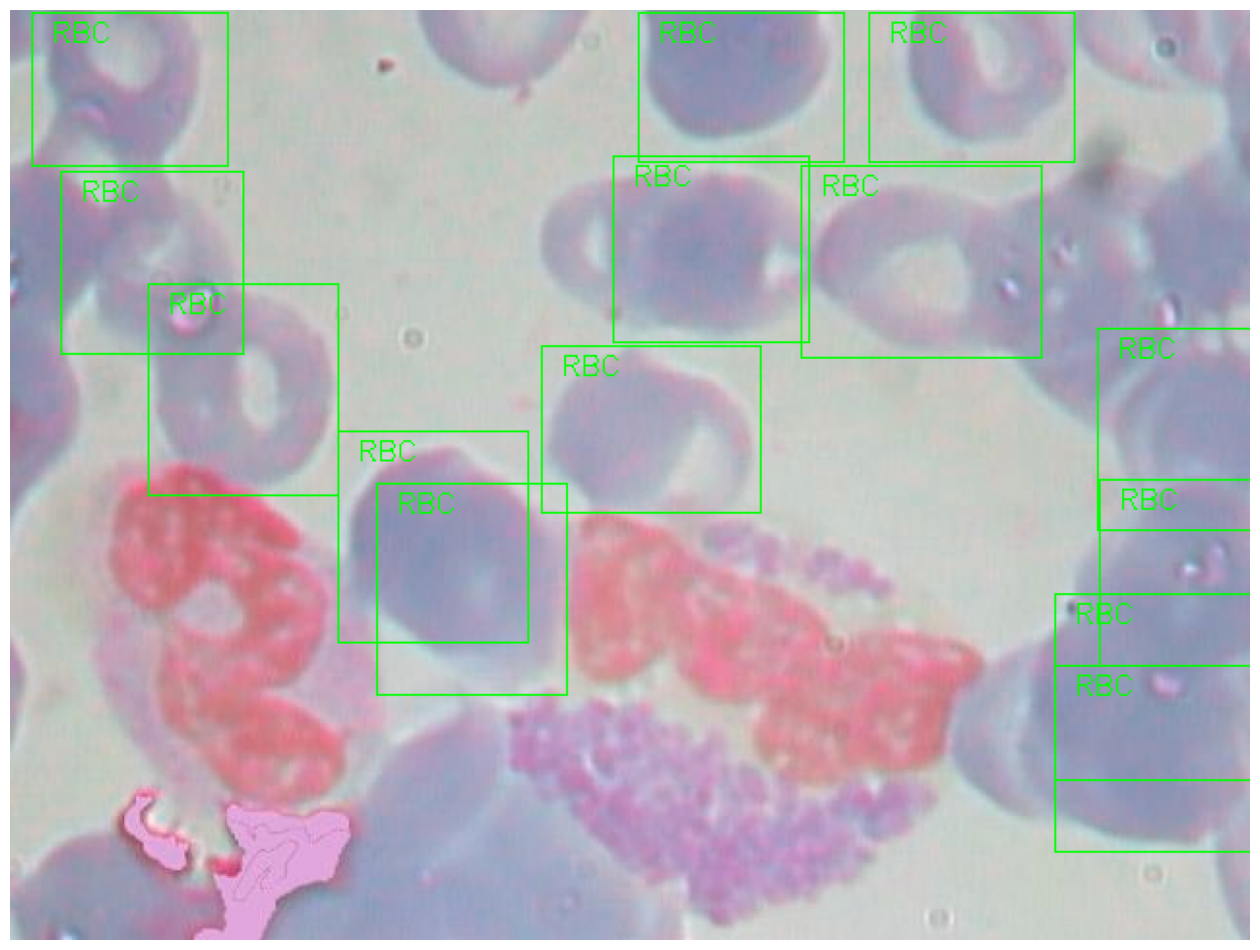

In [5]:
import xml.etree.ElementTree as ET
image_path = "/kaggle/input/blood-cells/dataset-master/dataset-master/JPEGImages/BloodImage_00010.jpg"
xml_path = "/kaggle/input/blood-cells/dataset-master/dataset-master/Annotations/BloodImage_00010.xml"
annotated_image = annotate_image(image_path, xml_path)

plt.figure(figsize=(16, 16))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()

In [6]:
#read the labels
labels_path ="/kaggle/input/blood-cells/dataset2-master/dataset2-master/labels.csv"
labels = pd.read_csv(labels_path)

In [7]:
labels.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Unnamed: 0,Image,Category
0,NaN,0,NEUTROPHIL
1,NaN,1,NEUTROPHIL
2,NaN,2,NEUTROPHIL
3,NaN,3,NEUTROPHIL
4,NaN,4,NEUTROPHIL
...,...,...,...
406,NaN,406,NaN
407,NaN,407,NEUTROPHIL
408,NaN,408,NEUTROPHIL
409,NaN,409,NEUTROPHIL


In [8]:
# Define augment images
import albumentations as A

augmenter = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,))  # Optional for model input
])

def augment_image(image):
    augmented = augmenter(image=image)
    return augmented['image']

In [9]:
#read the images and labele
from tqdm import tqdm
def get_images_labels(folder):
    X=[]
    y =[]
    wbc_label_map = {
    'NEUTROPHIL': 1,
    'EOSINOPHIL':2,
    'MONOCYTE': 3,
    'LYMPHOCYTE': 4
}

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            label = wbc_label_map.get(wbc_type, 5)
            for image_filename in tqdm(os.listdir(os.path.join(folder, wbc_type))):
                image_path = os.path.join(folder, wbc_type, image_filename)
                img_file = cv2.imread(image_path)

                if img_file is not None:
                    resized_img = cv2.resize(img_file, (80, 60))  # (width, height)
                    rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
                    image_aug = augment_image(rgb_img)
                    X.append(image_aug)
                    y.append(label)
    
    X=np.asarray(X)
    y=np.asarray(y)
    return X, y
        


In [10]:
train_folder ="/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/"
test_folder = "/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST/"
X_train, y_train = get_images_labels(train_folder)
X_test, y_test = get_images_labels(test_folder)


100%|██████████| 623/623 [00:03<00:00, 174.59it/s]


In [11]:
# nornalize the X-Train, X-test for RGB images
X_train = X_train / 255.0
X_test = X_test / 255.0

In [12]:
print("X_train shape:", np.shape(X_train))
print("y_train shape:", np.shape(y_train))
print("X_test shape:", np.shape(X_test))
print("y_test shape:", np.shape(y_test))

X_train shape: (9957, 60, 80, 3)
y_train shape: (9957,)
X_test shape: (2487, 60, 80, 3)
y_test shape: (2487,)


In [13]:
#CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
num_classes = 5 
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(60, 80, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761666628.133369      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [19]:
#define Confusion Matrix Callback
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class ConfusionMatrixLogger(Callback):
    def __init__(self, X_val, y_val, label_names, interval=5):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.label_names = label_names
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            y_pred = self.model.predict(self.X_val)
            y_pred_classes = np.argmax(y_pred, axis=1)
            y_true = np.argmax(self.y_val, axis=1) if len(self.y_val.shape) > 1 else self.y_val

            cm = confusion_matrix(y_true, y_pred_classes)
            print(f"\nConfusion Matrix at Epoch {epoch+1}:\n{cm}")

            # Optional: plot the matrix
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=self.label_names,
                        yticklabels=self.label_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix at Epoch {epoch+1}')
            plt.show()

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
label_names = ['NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE', 'OTHER']
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ConfusionMatrixLogger(X_test, y_test, label_names, interval=5)  # your custom callback
]

Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7572 - loss: 0.5744 - val_accuracy: 0.2493 - val_loss: 652.9923 - learning_rate: 0.0010
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8038 - loss: 0.4707 - val_accuracy: 0.2493 - val_loss: 701.8938 - learning_rate: 0.0010
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8221 - loss: 0.4145 - val_accuracy: 0.2493 - val_loss: 837.1819 - learning_rate: 0.0010
Epoch 4/50
309/312 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8525 - loss: 0.3643
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8524 - loss: 0.3645 - val_accuracy: 0.2493 - val_loss: 914.2856 - learning_rate: 0.0010
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step   - accuracy: 0.8769 - los

Confusion Matrix at Epoch 5:
[[  0   0 624   0]
 [  0   0 623   0]
 [  0   0 620   0]
 [  0   0 620   0]]


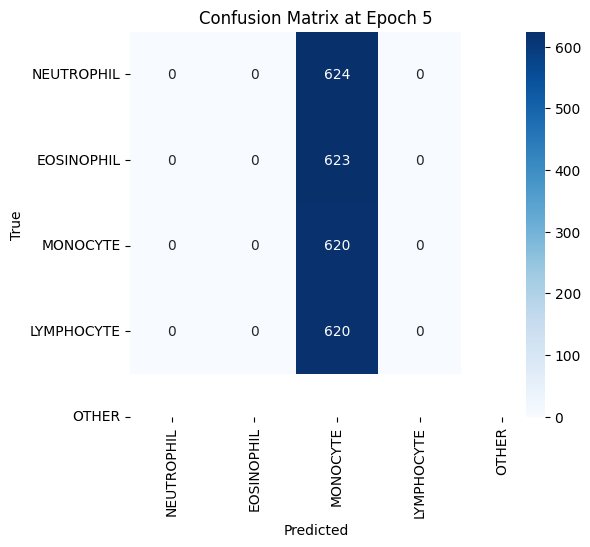

312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8770 - loss: 0.2985 - val_accuracy: 0.2493 - val_loss: 332.4807 - learning_rate: 5.0000e-04
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8762 - loss: 0.3064 - val_accuracy: 0.2505 - val_loss: 37.3240 - learning_rate: 5.0000e-04
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9103 - loss: 0.2316 - val_accuracy: 0.2525 - val_loss: 47.2960 - learning_rate: 5.0000e-04
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9247 - loss: 0.1951 - val_accuracy: 0.2493 - val_loss: 405.4831 - learning_rate: 5.0000e-04
Epoch 9/50
309/312 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9362 - loss: 0.1763
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9362 - loss: 0.1764 - val_accuracy: 0.2493 - val_loss: 126.3049 - learning_rate: 5.0000e-04
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step p - accuracy: 0.9385

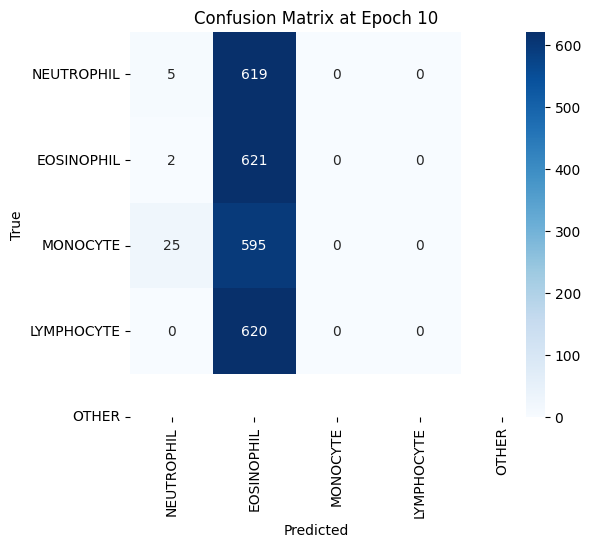

312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9386 - loss: 0.1598 - val_accuracy: 0.2517 - val_loss: 62.0591 - learning_rate: 2.5000e-04
Epoch 11/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9462 - loss: 0.1455 - val_accuracy: 0.3313 - val_loss: 31.3177 - learning_rate: 2.5000e-04
Epoch 12/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9605 - loss: 0.1200 - val_accuracy: 0.2786 - val_loss: 28.9692 - learning_rate: 2.5000e-04
Epoch 13/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9581 - loss: 0.1197 - val_accuracy: 0.6711 - val_loss: 1.3432 - learning_rate: 2.5000e-04
Epoch 14/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9621 - loss: 0.1086 - val_accuracy: 0.3530 - val_loss: 12.5690 - learning_rate: 2.5000e-04
Epoch 15/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step p - accuracy: 0.9645 - loss:

Confusion Matrix at Epoch 15:
[[  1 623   0   0]
 [  0 623   0   0]
 [  0 620   0   0]
 [  1 619   0   0]]


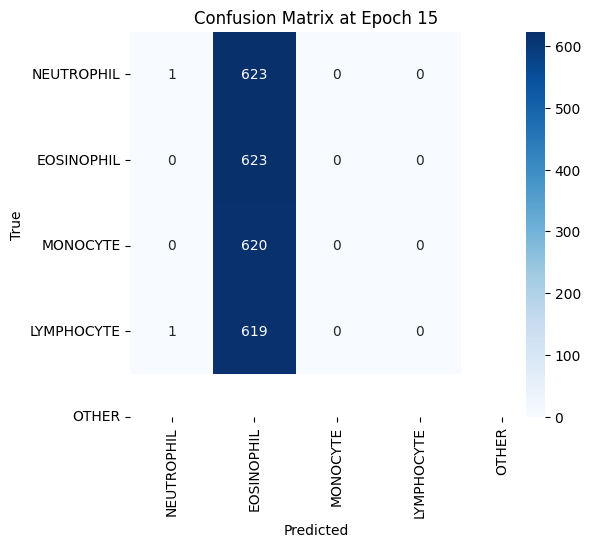

312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9645 - loss: 0.1007 - val_accuracy: 0.2509 - val_loss: 29.9002 - learning_rate: 2.5000e-04
Epoch 16/50
306/312 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9666 - loss: 0.0998
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9665 - loss: 0.0999 - val_accuracy: 0.2493 - val_loss: 382.5961 - learning_rate: 2.5000e-04
Epoch 17/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9695 - loss: 0.0955 - val_accuracy: 0.2947 - val_loss: 19.5577 - learning_rate: 1.2500e-04
Epoch 18/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9717 - loss: 0.0821 - val_accuracy: 0.4041 - val_loss: 10.1521 - learning_rate: 1.2500e-04


In [23]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=callbacks)

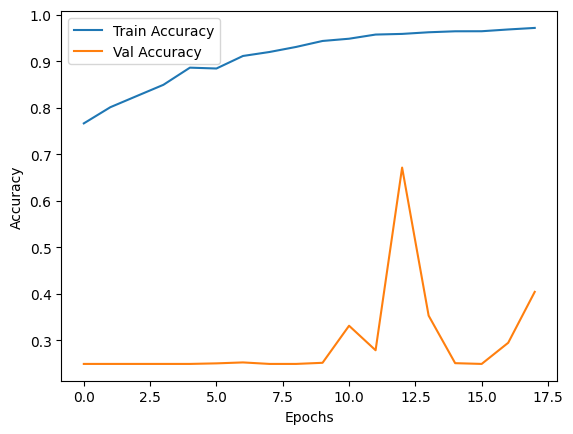

In [24]:
#view the loss and val-loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

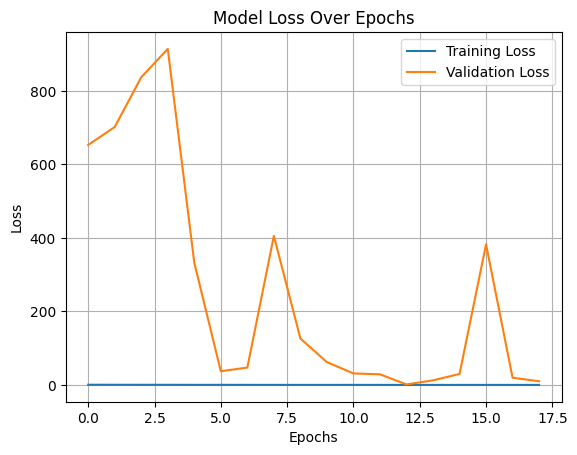

In [25]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()